# Analysis of Harvey flooding

Estimation of water input to Galveston Bay due to Hurricane Harvey precipitation.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
from scipy.optimize import curve_fit


In [5]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

plots = {'Water Level [m]': {'color': '0.1', 'marker': 'o', 's': 200, 'alpha': 1, 'linewidths': 2}, 
         'East [m/s]': {'color': 'w', 'marker': 'v', 's': 120, 'alpha': 1},
         'Salinity': {'color': 'w', 'marker': '*', 's': 280, 'alpha': 1}, 
         'Along [cm/s]': {'color': 'w', 'marker': '^', 's': 150, 'alpha': 1},
         'Rain [cm]': {'marker': 's', 's':200, 'alpha': 1},
         'Flow rate [m^3/s]': {'marker': '>', 's': 200, 'alpha': 1}}

base = 'drive_data/'

In [6]:
# # read in buoy info
# bys = pd.read_csv(base + 'buoys.csv', index_col=0).to_dict('index')

# buoys = {'BOLI': {'ll': ([-94.783, 29.342]), 'color': '#689F38', 'vars': ['Salinity'], 'llshift': (-0.05, -0.04)},
#          'MIDG': {'ll': ([-94.875, 29.508]),  'color': '#FBC02D', 'vars': ['Salinity']},
#          'FISH': {'ll': ([-94.854, 29.670]),  'color': '#F57C00', 'vars': ['Salinity']},
#          'TRIN': {'ll': ([-94.746, 29.661]),  'color': '#FFA000', 'vars': ['Salinity']},
#          'OLDR': {'ll': ([-94.783, 29.833]), 'color': '#D32F2F', 'vars': ['Salinity']},
#          '08078000': {'ll': ([-95.32283, 29.3713056]), 'color': '#D32F2F', 'vars': ['Flow rate [m^3/s]']},
#          '08077600': {'ll': ([-95.1783, 29.5172]), 'color': '#D32F2F', 'vars': ['Flow rate [m^3/s]'], 'llshift': (-0.22, 0)},
#          '08074500': {'ll': ([-95.39694, 29.775]), 'color': '#FFA000', 'vars': ['Flow rate [m^3/s]']},
#          '08068500': {'ll': ([-95.4361, 30.110278]), 'color': '#FFA000', 'vars': ['Flow rate [m^3/s]'], 'llshift': (0.02, -0.02)},
#          '08068090': {'ll': ([-95.3382, 30.141167]), 'color': '#FFA000', 'vars': ['Flow rate [m^3/s]'], 'llshift': (-0.04, 0.02)},
#          '08070500': {'ll': ([-95.302, 30.2594]), 'color': '#FFA000', 'vars': ['Flow rate [m^3/s]']},
#          '08071000': {'ll': ([-95.168056, 30.23250]), 'color': '#FFA000', 'vars': ['Flow rate [m^3/s]'], 'llshift': (0.02, -0.01)},
#          '08070200': {'ll': ([-95.124167, 30.145278]), 'color': '#FFA000', 'vars': ['Flow rate [m^3/s]']},
#          '08071280': {'ll': ([-95.05972, 30.1094]), 'color': '#FFA000', 'vars': ['Flow rate [m^3/s]'], 'llshift': (0.03, 0.0)},
#          '08067252': {'ll': ([-94.731, 29.812]), 'color': '#388E3C', 'vars': ['Flow rate [m^3/s]'], 'llshift': (0.0, 0.02)},
#          '08067000': {'ll': ([-94.818056, 30.0575]), 'color': '#388E3C', 'vars': ['Rain [cm]'], 'llshift': (0.03, 0)},
#          '08077650': {'ll': ([-94.92, 29.4472]), 'color': '#D32F2F', 'vars': ['Rain [cm]'], 'llshift': (-0.22, -0.01)},
#          '08073600': {'ll': ([-95.55750, 29.76194]), 'color': '#FFA000', 'vars': ['Rain [cm]'], 'llshift': (0.01, -0.06)},
#          '8771486': {'ll': ([bys['8771486']['lon'], bys['8771486']['lat']]),  'color': '#0097A7',
#                      'vars': ['Water Level [m]', 'East [m/s]', 'North [m/s]'], 'llshift': (-0.18, 0.01)},
#          '8770613': {'ll': ([bys['8770613']['lon'], bys['8770613']['lat']]),  'color': '#E64A19',
#                      'vars': ['Salinity'], 'llshift': (-0.02, 0.02)},
#          '8771013': {'ll': ([bys['8771013']['lon'], bys['8771013']['lat']]), 'color': '#AFB42B',
#                      'vars': ['Water Level [m]', 'Salinity'], 'llshift': (-0.15, 0.02)},
#          '8771341': {'ll': ([bys['8771341']['lon'], bys['8771341']['lat']]), 'color': '#388E3C',
#                      'vars': ['East [m/s]', 'North [m/s]']},
#          '8771450': {'ll': ([bys['8771450']['lon'], bys['8771450']['lat']]), 'color': '#00796B',
#                      'vars': ['Water Level [m]', 'East [m/s]', 'North [m/s]']},
#          'B': {'ll': ([bys['B']['lon'], bys['B']['lat']]), 'color': '#303F9F',
#                      'vars': ['East [m/s]', 'North [m/s]', 'Salinity', 'Along [cm/s]', 'Across [cm/s]']},
#          'g06010': {'ll': ([bys['g06010']['lon'], bys['g06010']['lat']]), 'color': '#455A64',
#                      'vars': ['Along [cm/s]'], 'llshift': (0.01, -0.04)},
#          '42035': {'ll': ([bys['42035']['lon'], bys['42035']['lat']]), 'color': '#5D4037',
#                      'vars': ['East [m/s]', 'North [m/s]']},
#          '8770808': {'ll': ([bys['8770808']['lon'], bys['8770808']['lat']]), 'color': '#512DA8',
#                      'vars': ['Water Level [m]', 'East [m/s]', 'North [m/s]']},
#          '8770777': {'ll': ([bys['8770777']['lon'], bys['8770777']['lat']]), 'color': '#C2185B',
#                      'vars': ['Water Level [m]', 'East [m/s]', 'North [m/s]']},
#          '8770822': {'ll': ([bys['8770822']['lon'], bys['8770822']['lat']]), 'color': '#455A64',
#                      'vars': ['Water Level [m]', 'East [m/s]', 'North [m/s]']},
#          '8770971': {'ll': ([bys['8770971']['lon'], bys['8770971']['lat']]), 'color': '#7B1FA2',
#                      'vars': ['Water Level [m]', 'East [m/s]', 'North [m/s]']},
#          '8771972': {'ll': ([bys['8771972']['lon'], bys['8771972']['lat']]), 'color': '#0288D1',
#                      'vars': ['Water Level [m]', 'East [m/s]', 'North [m/s]']}
#         }


buoys_ordered = ['8770777', '8770613', 'OLDR', 'FISH', 'TRIN', 'MIDG', '8771013', 'BOLI', 'g06010', '8771341',
                '8771450', '8771486', '8771972', '8770971', '8770808', 'B', '42035', '8770822']
# buoys down main bay
buoys_main = ['8770613', 'FISH', 'TRIN', 'MIDG', '8771013', 'BOLI', 'g06010', '8771341', '8771450']
# buoys used in analysis
buoys_used = ['MIDG', '8771013', 'g06010', 'BOLI', '8771486', '8771341', '8770613', '8771972']

In [7]:
# See make_data notebook. This reads in data from many sources, recalculates so that all data is hourly by taking 
# hourly averages, and shifts water levels to all be mean high water to match the bathymetry.
df = pd.read_csv(base + 'data06.csv', parse_dates=True, index_col=0)

dstart = '2017-06-01'; dend = '2017-12-31'

In [8]:
# read in bathymetry data, as calculated in notebook `bathy`
d = np.load(base + 'bathy_galv_clean.npz')  # all of Galveston Bay
bathy = d['bathy']; dx = d['dx']; dy = d['dy']; lon = d['lon']; lat = d['lat']
bathyw = np.load(base + 'bathy_galv_west.npz')['bathy']  # West Bay
bathym = np.load(base + 'bathy_galv_main.npz')['bathy']  # Rest of Galveston Bay
bathyo = np.load(base + 'bathy_every_fifth.npz')['bathy'][::-1,:][1:-1,1:-1]  # all
bathyo = np.ma.masked_where(bathyo>0, bathyo)

## Calculate mean speed for velocity profile at entrance channel

We have velocity information with depth, but are missing the bottom of the water column and about the top half due to the blanking distance and mount depth. We calculate mean for each profile assuming the velocity is constant above the top-most data and assuming the bottom goes to 0 speed.

In [9]:
depths = -np.unique([float(col.split('depth ')[1].split(' ')[0]) for col in df.columns if 'depth' in col])
depths = np.concatenate(([0], depths, [-12]))  # add 0 and 12

In [10]:
dates = df.index
smean = np.zeros(dates.size)
zmean = np.zeros(dates.size)

for i, date in enumerate(dates):

    s = np.zeros(len(depths))
    for j, depth in enumerate(depths):
        if depth == 0:  # make top of water column constant
            s[j] = df.loc[date,'g06010: Along [cm/s], depth %s [m]' % abs(depths[j+1])]
        elif depth == -12:
            s[j] = 0
        else:
            s[j] = df.loc[date,'g06010: Along [cm/s], depth %s [m]' % abs(depth)]

    # interpolate to fill in water column evenly
    zint = np.linspace(-12, 0, 1000)  # depths
    sint = np.interp(zint, depths[::-1], s[::-1])  # interpolated speed to depths

    # plt.plot(sint, zint, 'k')
    # plt.plot(s, depths, 'ro')

    smean[i] = sint.mean()  # mean speed for profile
    zmean[i] = zint[abs(sint - sint.mean()).argmin()]  # depth at which mean occurs
df['smean'] = smean
df['zmean'] = zmean

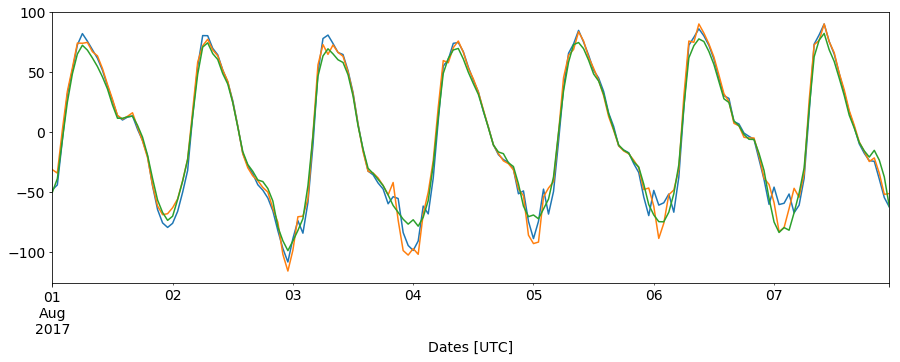

In [11]:
df['g06010: Along [cm/s], depth 5.79 [m]']['2017-8-1':'2017-8-7'].plot()
df['g06010: Along [cm/s], depth 6.8 [m]']['2017-8-1':'2017-8-7'].plot(figsize=(15,5))
df['smean']['2017-8-1':'2017-8-7'].plot(figsize=(15,5))

# Overall view of data locations

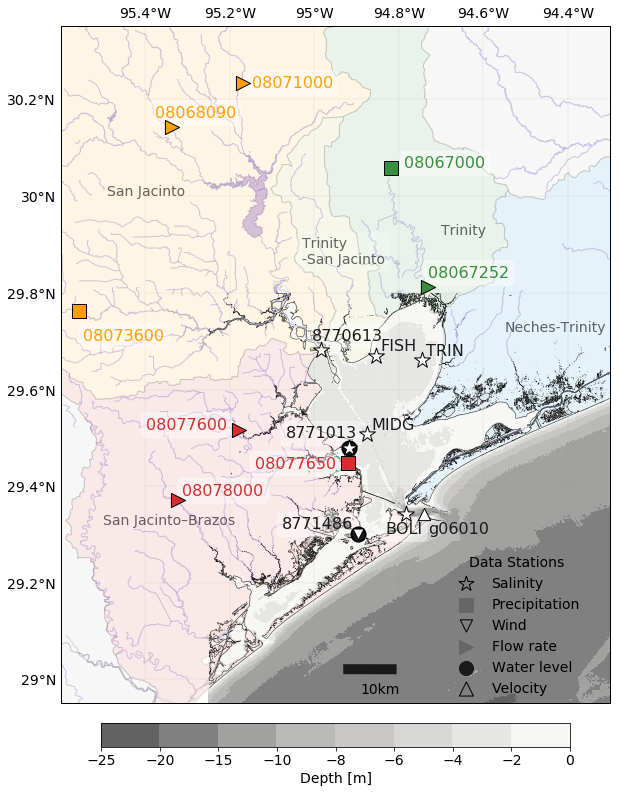

In [385]:
d = np.load('drive_data/bathy_galv_clean.npz')  # all of Galveston Bay
bathy = d['bathy']; dx = d['dx']; dy = d['dy']; lon = d['lon']; lat = d['lat']
bathyo = np.load('drive_data/bathy_every_fifth.npz')['bathy'][::-1,:][1:-1,1:-1]  # all
bathyo = np.ma.masked_where(bathyo>0, bathyo)

extent = [-95.6, -94.3, 28.95, 30.35]
import shapely
x1, x2, y1, y2 = extent
pts = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
ext = shapely.geometry.Polygon(pts)


fig = plt.figure(figsize=(14, 12))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent(extent, pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-95.4, -94, 0.2))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(29, 31, 0.2))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
mappable = ax.contourf(lon, lat, bathyo, [-25, -20, -15, -10, -8, -6, -4, -2, 0], vmin=-40, cmap=cmo.gray, transform=pc)
cb = fig.colorbar(mappable, orientation='horizontal', shrink=0.5, pad=0.025)
cb.set_label('Depth [m]')
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline


# Add river basins to plot
reader = cartopy.io.shapereader.Reader('drive_data/Major_River_Basins_Shapefile/TWDB_MRBs_2014.shp')
basins = reader.records()
for basin in basins:
    if basin.attributes['basin_name'] == 'San Jacinto-Brazos':
        facecolor = buoys['OLDR']['color']  # 'red'
    elif basin.attributes['basin_name'] == 'San Jacinto':
        facecolor = buoys['TRIN']['color']  # 'orange'
    elif basin.attributes['basin_name'] == 'Trinity-San Jacinto':
        facecolor = buoys['8771013']['color']  # 'yellow'
    elif basin.attributes['basin_name'] == 'Trinity':
        facecolor = buoys['8771341']['color']  # 'green'
    elif basin.attributes['basin_name'] == 'Neches-Trinity':
        facecolor = buoys['8771972']['color']  # 'blue'
    else:
        facecolor = '0.7'
    ax.add_geometries([basin.geometry], pc, facecolor=facecolor, edgecolor='k', linewidth=1, alpha=0.1)

watercolor = buoys['8770808']['color']

# Add lakes to plot
reader = cartopy.io.shapereader.Reader('drive_data/tceq_segments_2014_shp/TCEQ_SEGMENT_POLY_2014.shp')
lakes = reader.records()
for lake in lakes:
    if ext.contains(lake.geometry.centroid) and "Bay" not in lake.attributes['BASIN_NAME'] \
         and "Gulf" not in lake.attributes['BASIN_NAME']:
        ax.add_geometries([lake.geometry], pc, facecolor=watercolor, edgecolor=watercolor, alpha=0.25)

# Add rivers to plot
reader = cartopy.io.shapereader.Reader('drive_data/tceq_segments_2014_shp/TCEQ_SEGMENT_LINE_2014.shp')
rivers = reader.records()
for river in rivers:
    if ext.contains(river.geometry.centroid):
        ax.add_geometries([river.geometry], pc, facecolor='none', edgecolor=watercolor, alpha=0.25)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.4)
        
# add buoys
for buoy in ['MIDG', 'BOLI', '8771013', '8771486', 'TRIN', '8770613', 'FISH', 'g06010']:
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    if buoy in ['g06010', 'MIDG', 'FISH', 'TRIN']:  # no box
        ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=16, color='0.1')
    else:
        ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=16, color='0.1', bbox=props)
    for var in buoys[buoy]['vars']:
        if var in plots:
            ax.scatter(*buoys[buoy]['ll'], **plots[var], transform=pc, label=var, edgecolors='k', zorder=5)

# Add precipitation stations
for buoy in ['08067000', '08073600', '08077650']:
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=16, color=buoys[buoy]['color'], bbox=props)
    ax.scatter(*buoys[buoy]['ll'], color=buoys[buoy]['color'], **plots['Rain [cm]'], transform=pc, label=var, edgecolors='k', zorder=5)

# Add rain gauges
for buoy in ['08078000', '08077600', '08068090', '08071000', '08067252']:
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=16, color=buoys[buoy]['color'], bbox=props)
    ax.scatter(*buoys[buoy]['ll'], color=buoys[buoy]['color'], **plots['Flow rate [m^3/s]'], transform=pc, label=var, edgecolors='k', zorder=5)

# Add labels
ax.text(-95.49, 30.0, 'San Jacinto', transform=pc, alpha=0.6)
ax.text(-95.03, 29.86, 'Trinity\n-San Jacinto', transform=pc, alpha=0.6, bbox=dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.2))
ax.text(-95.5, 29.32, 'San Jacinto–Brazos', transform=pc, alpha=0.6)
ax.text(-94.7, 29.92, 'Trinity', transform=pc, alpha=0.6)
ax.text(-94.55, 29.72, 'Neches-Trinity', transform=pc, alpha=0.6);

# Distance key
llon, llat = -94.92, 29.02
eqproj = cartopy.crs.AzimuthalEquidistant(central_longitude=-95, central_latitude=30)
lx, ly = eqproj.transform_point(llon, llat, pc)  # convert to projection
ax.plot([lx, lx+10e3], [ly, ly], lw=10, transform=eqproj, color='0.1')
ax.text(llon+0.03, llat-0.05, '10km', transform=pc)

# Add legend
ax2 = fig.add_axes([0.65, 0.17, 0.13, 0.3], frameon=False)
ax2.scatter([], [], c='none', linewidths=1, s=250, marker='*', edgecolors='k', label='Salinity')
ax2.scatter([], [], c='0.4', s=200, marker='s', label='Precipitation')
ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=150, marker='v', label='Wind')
ax2.scatter([], [], c='0.4', s=200, marker='>', label='Flow rate')
ax2.scatter([], [], c='0.1', s=200, marker='o', label='Water level')
ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=200, marker='^', label='Velocity', alpha=1)

ax2.legend(scatterpoints=1, frameon=False, title='Data Stations', loc='lower right')
ax2.set_axis_off()

fig.savefig('figures/map_full.png', bbox_inches='tight', dpi=300)


## Summary of ocean/met conditions

Hurricane Harvey started as a TYPE OF STORM on DATE WHERE, and became MAJOR STORM NAME just before hitting the coast near Corpus Christi (MORE SPECIFIC?) at 03:00 UTC August 25th (NOAA REPORT). Harvey then traveled slowly offshore where it sat and dumped out rain for HOW LONG onto the eastern Texas region, especially Houston (CITE NOAA REPORT?).

In the region of watersheds that feed Galveston Bay, rain began to fall mid-day on August 25th (UTC)
DESCRIBE PLOTS


Though the impact of the storm surge associated with the initial landing of Hurricane Harvey was not major in the Galveston Bay region (CITE), the probable signal can be seen in, for example, the water level at NOAA station 8771972 01:00 August 26th (UTC), 22 hours after the landing. The propagation of the surge into Galveston Bay is difficult to discern among the complex coincident dynamics and would have occurred before the analysis in this paper, so is not considered further.

*Note*
Maybe the water level is raised before the rain comes because of the storm surge, and then the floodwater comes in to keep it raised. The time period for integrating is more based on velocity than water surface so i think its ok

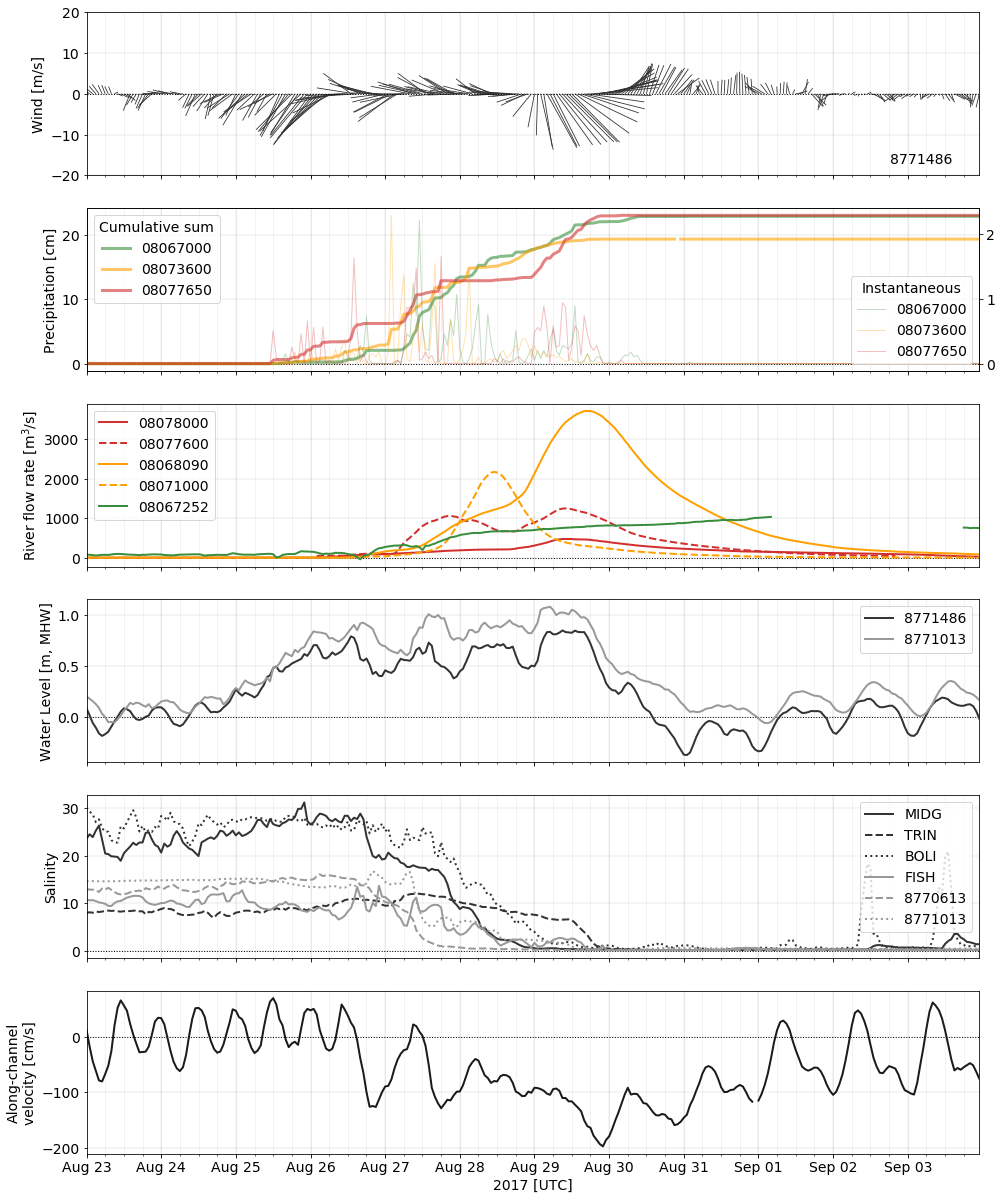

In [380]:
# define short dataframe to simplify plotting
dsp = '2017-08-23'; dep = '2017-09-3'
ddt = 1
dfsh = df.copy()[::ddt][dsp:dep]
dfsh['idx'] = date2num(pd.to_datetime(dfsh.index).to_pydatetime())
width = 0.2

fig, axes = plt.subplots(6, 1, figsize=(16,21), sharex=True)

    
## Wind ##
buoy = '8771486'
axes[0].quiver(dfsh['idx'], np.zeros(len(dfsh)), dfsh[buoy + ': East [m/s]'], dfsh[buoy + ': North [m/s]'], 
               headaxislength=0, headlength=0, width=width, units='y', scale_units='y', scale=1, 
               color='0.2', label=buoy)
axes[0].text(0.9, 0.075, buoy, fontsize=14, transform=axes[0].transAxes)
    
    
## Precipitation ##
ax1 = axes[1].twinx()
bs = ['08067000', '08073600', '08077650']
for i, buoy in enumerate(bs):
    ax1.plot(dfsh.index, dfsh[buoy + ': Rain [cm]'], color=buoys[buoy]['color'], lw=1, alpha=0.3)
    axes[1].plot(dfsh.index, dfsh[buoy + ': Rain [cm]'].cumsum(), color=buoys[buoy]['color'], lw=3, alpha=0.6)
axes[1].legend(bs, loc='upper left', title='Cumulative sum')
ax1.legend(bs, loc='lower right', title='Instantaneous')


## River Gauges ##
bs = ['08078000', '08077600', '08068090', '08071000', '08067252']
linestyles = ['-', '--', '-', '--', '-']
for buoy, ls in zip(bs, linestyles):
    axes[2].plot(dfsh.index, dfsh[buoy + ': Flow rate [m^3/s]'], color=buoys[buoy]['color'], lw=2, ls=ls)
axes[2].legend(bs, loc='upper left')


## Sea Level ##
for buoy, col in zip(['8771486', '8771013'], ['0.2', '0.6']):
    axes[3].plot(dfsh.index, dfsh[buoy + ': Water Level [m]'], label=buoy, color=col, lw=2)
axes[3].legend()
    
    
## Salinity ##
bs = ['MIDG', 'TRIN', 'BOLI', 'FISH', '8770613', '8771013']
linestyles = ['-', '--', ':', '-', '--', ':']
colors = ['0.2', '0.2', '0.2', '0.6', '0.6', '0.6']
for buoy, ls, col in zip(bs, linestyles, colors):
    axes[4].plot(dfsh.index, dfsh[buoy + ': Salinity'], label=buoy, color=col, lw=2, ls=ls)
axes[4].legend(loc='best')


## Entrance along-channel velocity ##
axes[5].plot(dfsh.index, dfsh['smean'], color='0.1', lw=2)


# labels
axes[0].set_ylabel('Wind [m/s]')
axes[1].set_ylabel('Precipitation [cm]')
axes[2].set_ylabel('River flow rate [m$^3$/s]')
axes[3].set_ylabel('Water Level [m, MHW]')
axes[4].set_ylabel('Salinity')
axes[5].set_ylabel('Along-channel\nvelocity [cm/s]')

axes[0].set_ylim(-20,20)
axes[0].set_xlim(dfsh.index[0], dfsh.index[-1])
for ax in axes:
    ax.hlines(0, dfsh.index[0], dfsh.index[-1], linewidth=1, linestyle=':')
    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)

minor = mpl.dates.HourLocator(byhour=np.arange(0,24,6))
ax.xaxis.set_minor_locator(minor)
major = mpl.dates.HourLocator(byhour=np.arange(0,24,24))
ax.xaxis.set_major_locator(major)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))

handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(), loc='upper right')   

ax.set_xlabel('2017 [UTC]')

plt.savefig('figures/conditions.pdf', bbox_inches='tight')

## Flushing timescales and explain input timing of freshwater

EXPLAIN THEORY

DERIVE FUNCTION

SUMMARIZE RESULTS

In [33]:
times = {'FISH': {'starts': ['2017-8-26 22:00'], 'stops': ['2017-8-30 12:00']},
        'MIDG': {'starts': ['2017-8-26 16:00'], 'stops': ['2017-8-29 00:00']},
        'TRIN': {'starts': ['2017-8-27 12:00','2017-8-27 12:00', '2017-8-29 12:00'], 'stops': ['2017-9-1 00:00', '2017-8-29 12:00', '2017-9-1 00:00']},
        'BOLI': {'starts': ['2017-8-27 16:00'], 'stops': ['2017-8-30 00:00']},
        '8770613': {'starts': ['2017-8-26 16:00', '2017-8-26 16:00','2017-8-27 08:00'], 'stops': ['2017-8-29 00:00','2017-8-27 08:00','2017-8-29 00:00']},
        '8771013': {'starts': ['2017-8-27 08:00'], 'stops': ['2017-8-29 20:00']}}

saltcols = [col for col in df.columns if 'Salinity' in col]
saltcols = [col for col in saltcols if not 'OLDR' in col]
saltcols = [col for col in saltcols if not 'B:' in col]
saltcols

# get some datetime numbers to use in calculation
df['idx'] = date2num(df.index.to_pydatetime())


In [391]:

def flushing(t, S0, tau):
    '''exponential function.'''

    return S0*np.exp(-t/tau)


FISH time to 0.4: 1.07, time to 0.05: 3.49
MIDG time to 0.4: 1.08, time to 0.05: 3.54
TRIN time to 0.4: 1.39, time to 0.05: 4.54
BOLI time to 0.4: 0.74, time to 0.05: 2.42
8770613 time to 0.4: 0.53, time to 0.05: 1.75
8771013 time to 0.4: 0.88, time to 0.05: 2.89


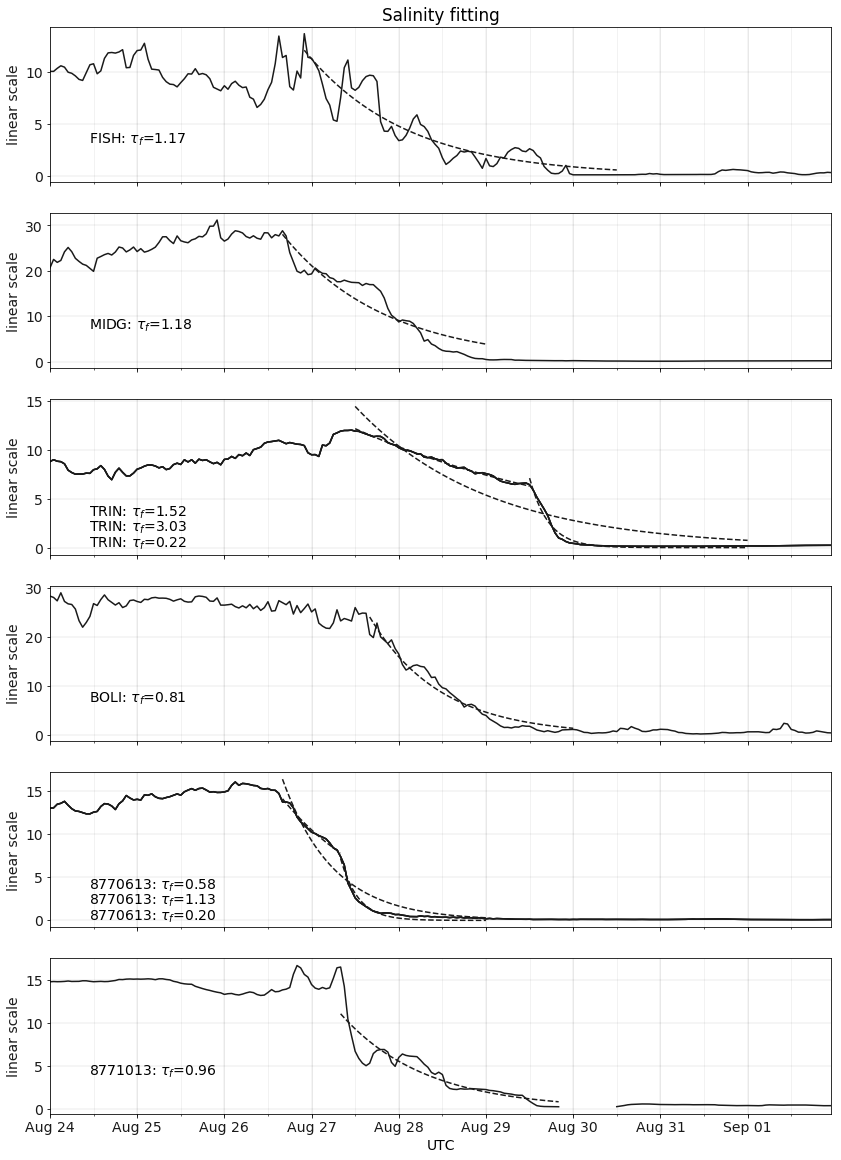

In [404]:
dst = '2017-8-24'; den = '2017-9-1'
fig, axes = plt.subplots(len(saltcols), 1, figsize=(14,20), sharex=True)

taus = np.empty(len(saltcols))
for j, (col, ax) in enumerate(zip(saltcols, axes)):
    

    # get fit in linear space
    name = col.split(':')[0]
    for i, (start, stop) in enumerate(zip(times[name]['starts'], times[name]['stops'])):

        d1 = start; d2 = stop
        tnums = df['idx'][d1:d2] - df['idx'][d1]

        fit = curve_fit(flushing, tnums, df[col][d1:d2].interpolate(), bounds=(0,30))
        data_fit = flushing(tnums, *fit[0])
        if i == 0:  # only take overall tau
            taus[j] = fit[0][1]
        tau = fit[0][1]

        # linear
        color = '0.1'
        ax.plot(df[dst:den].index, df[col][dst:den], color=color)  # plot data
        ax.plot(df[d1:d2].index, data_fit, '--', color=color)  # plot fit
        ax.tick_params(labelcolor=color)
        ax.set_ylabel('linear scale', color=color)
 
        # write station name and tau
        ax.text(0.05, 0.25 - i*0.1, name + r': $\tau_f$=%1.2f' % tau, transform=ax.transAxes)
        
        if i == 0:
            print('%s time to 0.4: %1.2f, time to 0.05: %1.2f' % (name, -tau*np.log(0.4), -tau*np.log(0.05)))
    
    hours = mpl.dates.HourLocator(byhour=np.arange(0,24,12))
    ax.xaxis.set_minor_locator(hours)
    days = mpl.dates.HourLocator(byhour=np.arange(0,24,24))
    ax.xaxis.set_major_locator(days)

    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)

axes[0].set_title('Salinity fitting')
axes[-1].set_xlabel('UTC')
axes[-1].autoscale(enable=True, axis='x', tight=True)


# df[[col for col in df.columns if 'log' in col]]['2017-8-24':'2017-9-3'].plot(figsize=(14,15), legend=True, subplots=True);

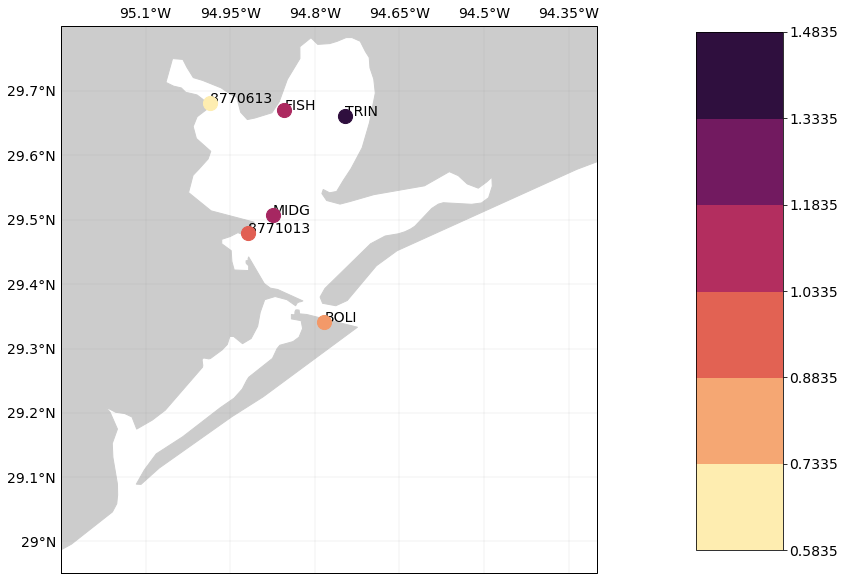

In [413]:
base = 'drive_data/'
d = np.load(base + 'bathy_galv_clean.npz')  # all of Galveston Bay
bathy = d['bathy']; dx = d['dx']; dy = d['dy']; lon = d['lon']; lat = d['lat']
bathyo = np.load(base + 'bathy_every_fifth.npz')['bathy'][::-1,:][1:-1,1:-1]  # all
bathyo = np.ma.masked_where(bathyo>0, bathyo)

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.25, -94.3, 28.95, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

# plot buoys
vmin = taus.min(); vmax = taus.max()
for saltcol, tau in zip(saltcols, taus):
    buoy = saltcol.split(':')[0]
    mappable = ax.scatter(*buoys[buoy]['ll'], c=tau, s=200, transform=pc, zorder=10, vmin=vmin, vmax=vmax, cmap=cmo.matter)
    ax.text(*buoys[buoy]['ll'], buoy, transform=pc)
# cb = plt.colorbar(mappable)

ax2 = fig.add_axes([0.95, 0.05, 0.1, 0.9])
cmap = cmo.matter
bounds = np.arange(vmin, vmax, 0.15)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                # to use 'extend', you must
                                # specify two extra boundaries:
                                boundaries=bounds,
                                ticks=bounds,  # optional
                                spacing='proportional')


# cb.set_label('Timescale [days]')

want to say
* when flushing started
* mention that individual events at each station can be faster or slower than overall timescale
* give results for timescales and delta times and absolute datetime for % salinity reduction
* reference Rayson paper
* time from set date to 2 psu or similar

Table showing timing with results:

In [414]:
for saltcol, tau in zip(saltcols, taus):
    name = saltcol.split(':')[0]
    print('%s start date/time: %s, tau: %s' % (saltcol, times[name]['starts'][0], tau))

FISH: Salinity start date/time: 2017-8-26 22:00, tau: 1.16616257898
MIDG: Salinity start date/time: 2017-8-26 16:00, tau: 1.18247172514
TRIN: Salinity start date/time: 2017-8-27 12:00, tau: 1.51587091509
BOLI: Salinity start date/time: 2017-8-27 16:00, tau: 0.809321157335
8770613: Salinity start date/time: 2017-8-26 16:00, tau: 0.583532835487
8771013: Salinity start date/time: 2017-8-27 08:00, tau: 0.964410835908


# 1. Calculate channel flux from Galveston Bay

We calculate the flux through Galveston channel, $Q_{ch}$, in two ways — one directly from data and one through conservation of salinity in the bay. The first should be good over time, regardless of the salinity state, but has large error because the data is at a single $x,y,z$ location and is assumed to be uniform across the whole channel. The second is only valid when there is salinity in the bay which is not true during the major flooding event. However, we use it to reduce the error in the first method.

We assume that any outflow from the West and East bays is insignificant.

## 1a. From current meter in channel

$\begin{align}
Q_{ch} &= \iint_A U_{ch}(t) \, dA  \\
~ &\approx U_{ch} \cdot A
\end{align}$

where the integral of the along-channel velocity, $U_{ch}$, of a cross-section of Galveston channel is approximated by the along-channel velocity at buoy `g06010` times the approximate cross-sectional area, width $W$ times depth $D$. Instead of estimating the cross-sectional area of the channel, we leave this constant as a parameter to be estimated by comparing with the salinity conservation method. This parameter will include errors in the method too.

In [12]:
# negative sign because original orientation is positive into the bay
Uch = -df['smean']/100.  # m/s

## 1b. From salinity conservation

Conservation of salinity in Galveston Bay gives:

$
\begin{align}
\partial (S V)/\partial t &= S_{in}Q_{in} - S_{ch} Q_{ch} \\
\partial (S V)/\partial t &= - S_{ch} Q_{ch} \\
\Rightarrow Q_{ch} &= -\frac{1}{S_{ch}} \frac{\partial (S V)}{\partial t}
\end{align}
$

where the input salinity, $S_{in}$, is assumed to be fresh so $S_{in}=0$ and $S_{ch}$ is the channel salinity.

We have data from TWDB station BOLI to represent $S_{ch}$ but the resulting inflow calculation has a linear relationship with the salinity representation of the water in the bay, $S(t)$, so we need to treat this carefully in particular.

Rayson et al 2017 finds that the volume-averaged salinity along the bay tends to be located around 30km from the mouth of the bay, which is approximately where the TWDB MIDG station is located. This is shown in their Figure 3. Therefore, we use the MIDG station to represent the average salinity of the bay, $S(t)$.

Note that we include the main (middle part plus Trinity bay) and east bays of Galveston only for all calculations because previous work (Powell 2003, Rayson 2015) have shown connectivity between salinity in these two areas but limited mixing with the West Bay. We will not use the West Bay of Galveston for any calculation in this work.

The derivative term is calculated as follows, where the volume is approximated as the surface area times the average depth plus a representative sea surface height:

$
\begin{align}
    \frac{\partial (S V)}{\partial t} &= A \frac{\partial [S(H+\eta)]} {\partial t}.
\end{align}
$

We calculate this term for both of the bays (main and east).

Surface area of the bay is calculated using bathymetry of Galveston Bay as calculated in `bathy` notebook.

In [13]:
# Main bay surface area
Am = np.nansum(~np.isnan(bathym)*dx*dy)

# Full Galveston Bay
Afull = np.nansum(~np.isnan(bathy)*dx*dy)

# West Bay
Aw = np.nansum(~np.isnan(bathyw)*dx*dy)

# Average depth for main bays
Hm = -np.nanmean(bathym)

# Average depth for full galv bay
Hfull = -np.nanmean(bathy)
# Average depth for west bay
Hw = -np.nanmean(bathyw)


In [14]:
S = (0.33*df['MIDG: Salinity'] + 0.33*df['BOLI: Salinity'] + 0.33*df['TRIN: Salinity'])
Sch = df['BOLI: Salinity']

eta = df['8771013: Water Level [m]']  # m, for main bay
etaw = df['8771486: Water Level [m]']  # m, for dealing with west bay separately

# Full Galveston Bay, west bay salinity as MIDG (same as main bay)
SV = Am*S*(eta+Hm) + Aw*S*(etaw+Hw)
dSVdt = SV.diff()/3600.  # divide by 3600 seconds for an hour frequency


We can then calculate the pre-storm channel flux as follows from salinity conservation:

In [15]:
# full galv bay, west bay salinity as midg
Qch1b = dSVdt/-Sch

## Combining methods to get best $Q_{ch}$

Salinity conservation (method 1b) gives us a more robust calculation for the channel flux, but it isn't meaningful after the whole bay is fresh. Thus, we combine this with applying current data uniformly across the channel (method 1a) to get an improved estimate.

We seek a fixed constant to improve the comparison of $U_{ch}$ with Qout1b. So, we use a linear fit between the two functions over the time period before Hurricane Harvey, from July 1 through August 24th.

In [16]:
def fixed_line(x, slope):
    '''line fixed to origin.'''

    return slope*x


ValueError: array must not contain infs or NaNs

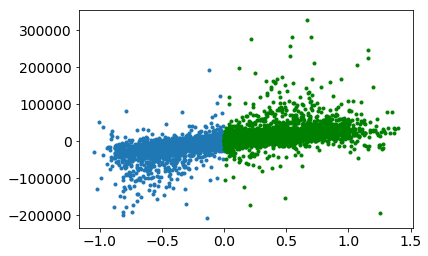

In [20]:

dst1 = '2010-1-1'; det1 = '2017-8-24'
# try splitting into ebb and flood for fit
ind = (~Uch[dst1:det1].isnull()) & (~Qch1b[dst1:det1].isnull()).values
indf = ind[Uch[dst1:det1] < 0]  # into the bay, flood tide, since switched sign already
inde = ind[Uch[dst1:det1] >= 0]  # out of the bay, ebb tide
Uf = Uch[dst1:det1][Uch[dst1:det1] < 0].copy()
Qf = Qch1b[dst1:det1][Uch[dst1:det1] < 0].copy()
Ue = Uch[dst1:det1][Uch[dst1:det1] >= 0].copy()
Qe = Qch1b[dst1:det1][Uch[dst1:det1] >= 0].copy()


# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca.fit(np.vstack((Uf, Qf)).T)
# print(pca.components_)
# print(pca.explained_variance_)
# print(pca.mean_)

# # pf = np.polyfit(Uf, Qf, 1)  # fit a straight line (order is 1)
# # print(pf)
# # pe = np.polyfit(Ue, Qe, 1)  # fit a straight line (order is 1)
# # print(pe)

fig, ax = plt.subplots(1,1)
ax.plot(Uf, Qf, '.', ms=6)
# ax.plot(Uf, np.polyval(pf, Uf), 'm', lw=2)
ax.plot(Ue, Qe, '.', ms=6, color='g')
# ax.plot(Ue, np.polyval(pe, Ue), 'y', lw=2)



fitf = curve_fit(fixed_line, Uf, Qf)#, bounds=(0,30))
data_fit = fixed_line(Uf, *fitf[0])
print(fitf)
ax.plot(Uf, data_fit, '--')  # plot fit

fite = curve_fit(fixed_line, Ue, Qe)#, bounds=(0,30))
data_fit = fixed_line(Ue, *fite[0])
print(fite)
ax.plot(Ue, data_fit, '--')  # plot fit

# Qcht = Uch[dst1:det1]
# Qcht[Uch[dst1:det1] < 0] = Uf*fitf[0]
# Qcht[Uch[dst1:det1] >= 0] = Ue*fite[0]

Qcht = Uch.copy()
Qcht[Uch < 0] = Uch[Uch < 0]*fitf[0]
Qcht[Uch >= 0] = Uch[Uch >= 0]*fite[0]

Qch = Qcht.copy()

# ax.plot()

# Qcht = Uch[dst1:det1]
# Qcht[Uch[dst1:det1] < 0] = Uf*pf[0]
# Qcht[Uch[dst1:det1] >= 0] = Ue*pe[0]
# # Qcht = Uf*pf[0]
# # Qcht[~Ue.isnull()] = Ue[~Ue.isnull()]*pe[0]  # m^3/s
# # Qcht

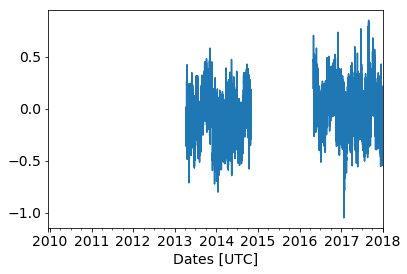

In [27]:
etaw.plot()

In [153]:
Qint = Qcht + dVdt + dVwdt
Vincumt = (Qint.interpolate()).cumsum()*3600  # multiply by time for integration, m^3
Qbt = (Vincumt.loc['2017-8-24 23:00'] - Vincumt.loc['2017-8-1 00:00'])/1000**3
print(Qbt)
print((Vincumt.loc['2017-9-7 00:00'] - Vincumt.loc['2017-8-26 16:00'])/1000**3)

0.635015612477
21.9466528541


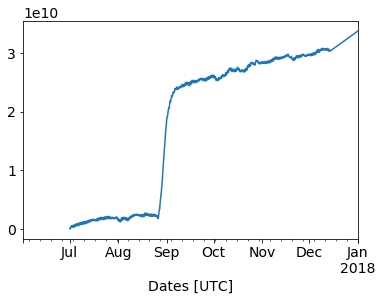

In [154]:
Vincumt.plot()

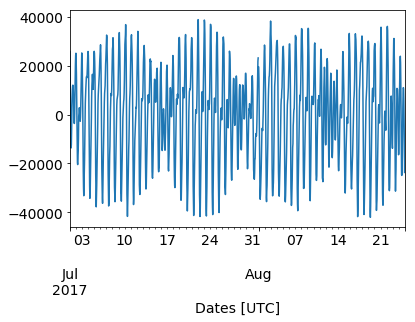

In [36]:
Qcht.plot()

[ 32864.81073764  -1209.80365842]
[ 49969.43300601  -7461.07591039]


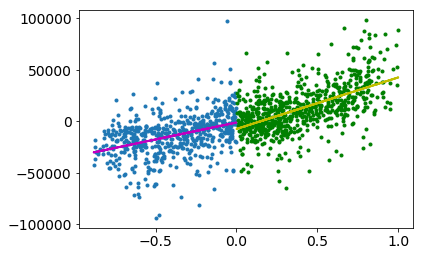

In [66]:

dst1 = '2017-7-1'; det1 = '2017-8-24'
# try splitting into ebb and flood for fit
ind = (~Uch[dst1:det1].isnull()) & (~Qch1b[dst1:det1].isnull()).values
indf = ind[Uch[dst1:det1] < 0]  # into the bay, flood tide, since switched sign already
inde = ind[Uch[dst1:det1] >= 0]  # out of the bay, ebb tide
Uf = Uch[dst1:det1][Uch[dst1:det1] < 0]
Qf = Qch1b[dst1:det1][Uch[dst1:det1] < 0]
Ue = Uch[dst1:det1][Uch[dst1:det1] >= 0]
Qe = Qch1b[dst1:det1][Uch[dst1:det1] >= 0]
pf = np.polyfit(Uf, Qf, 1)  # fit a straight line (order is 1)
print(pf)
pe = np.polyfit(Ue, Qe, 1)  # fit a straight line (order is 1)
print(pe)

fig, ax = plt.subplots(1,1)
ax.plot(Uf, Qf, '.', ms=6)
ax.plot(Uf, np.polyval(pf, Uf), 'm', lw=2)
ax.plot(Ue, Qe, '.', ms=6, color='g')
ax.plot(Ue, np.polyval(pe, Ue), 'y', lw=2)

Qcht = Uch[dst1:det1]
Qcht[Uch[dst1:det1] < 0] = Uf*pf[0]
Qcht[Uch[dst1:det1] >= 0] = Ue*pe[0]
# Qcht = Uf*pf[0]
# Qcht[~Ue.isnull()] = Ue[~Ue.isnull()]*pe[0]  # m^3/s
# Qcht

In [67]:
Qint = Qcht + dVdt
Vincumt = Qint.cumsum()*3600  # multiply by time for integration, m^3
Qbt = (Vincumt.loc['2017-8-24 23:00'] - Vincumt.loc['2017-8-1 00:00'])/1000**3
print(Qbt)


11.0182616362


[ 42989.28333403  -1508.14030659]


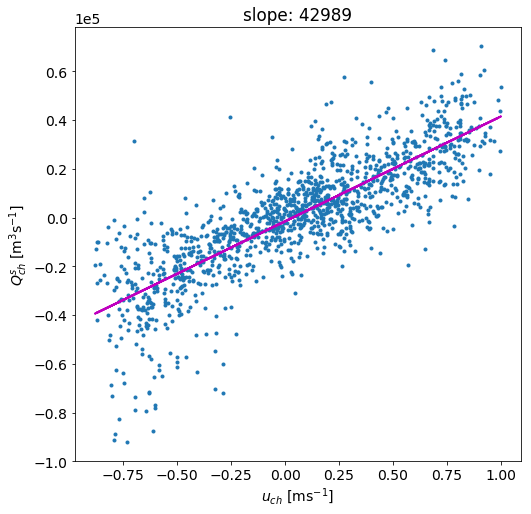

In [93]:
# Use linear fit to find relationship between measurements.
dst1 = '2017-7-1'; det1 = '2017-8-24'

# Demonstrate fit of line
fig, ax = plt.subplots(1,1,figsize=(8,8))

# loop through fits
ind = (~Uch[dst1:det1].isnull()) & (~Qch1b[dst1:det1].isnull()).values
p = np.polyfit(Uch[dst1:det1].loc[ind], Qch1b[dst1:det1].loc[ind], 1)  # fit a straight line (order is 1)
ax.plot(Uch[dst1:det1], Qch1b[dst1:det1], '.', ms=6)
ax.plot(Uch[dst1:det1], np.polyval(p, Uch[dst1:det1]), 'm', lw=2)
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax.set_xlabel('$u_{ch}$ [ms$^{-1}$]')
ax.set_title('slope: %3d' % p[0])
print(p)
    
ax.set_ylabel('$Q^s_{ch}$ [m$^3$s$^{-1}$]')
fig.savefig('figures/linear_regression_Qch_only.pdf', bbox_inches='tight')

The improved channel flux is the the data-based method (1a) times the slope of the fit between the two methods. The constant factor (p[0]) represents the cross-sectional area of the channel at the location of the current meter times an error factor accounting for the fact that the channel flow is not uniform across the channel nor with depth.

Note that since the p[0] accounts for both channel area and an error factor, its units are m$^2$.

In [13]:
# this is now the improved flux calculation which applies during the storm too

# full: MIDG
Qch = Uch*p[0]

With this adjustment, the two approaches align well before the storm, as seen in the figure below. The salinity conservation approach (method 1b) does not give reasonable results once the bay is too fresh (around August 28th).

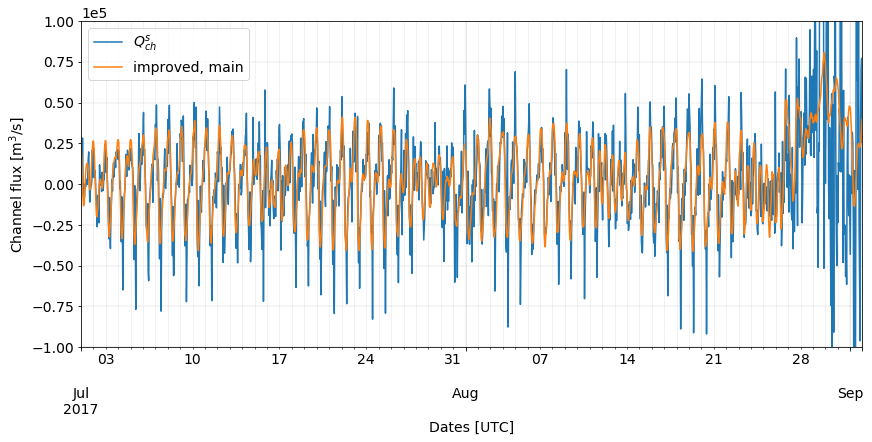

In [145]:
dst2 = '2017-7-1'; det2 = '2017-9-1'

fig, ax = plt.subplots(1, 1, figsize=(14,6), sharex=True, sharey=True)

Qch1b[dst2:det2].plot(ax=ax, label='$Q^s_{ch}$')
Qch[dst2:det2].plot(label='improved, main', ax=ax)
ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
ax.grid(which='minor', lw=1, color='k', alpha=0.05)
    
ax.legend()
ax.set_ylabel('Channel flux [m$^3$/s]')
ax.set_ylim(-1e5, 1e5)
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
# plt.savefig('figures/channel_flux_improved_only.pdf', bbox_inches='tight')

This number is the equivalent area of the channel cross-section — it is the area times a factor to account for errors in assuming a constant along-channel velocity across the channel and with depth.

The cross-sectional area is approximately:

In [98]:
W = 2500  # meters, calculated with length tool in google earth

D = (250*22 + 325*34 + 1050*45 + 425*35 + 50*24 + 100*17 + 300*1)/2500  # feet
D /= 3.28084  # meters
W*D  # m^2

24955.499201424027

meaning that the equivalent area is

In [128]:
print(fitf[0]/(W*D), fite[0]/(W*D))

[ 1.87099744] [ 1.64396055]


times the area of the channel there and therefore is in the right ballpark.

# 2. Calculate inflow to Galveston Bay

For this we use a control volume of Galveston Bay with the previously-calculated function for $Q_{ch}$

$\begin{align}
\partial V/\partial t &= Q_{in} - Q_{ch} ~~~~~~~~(1) \\
\Rightarrow Q_{in}(t) &= Q_{ch}(t) + \partial V/\partial t
\end{align}$

where $V(t)$ is the volume of Galveston Bay, $Q_{in}(t)$ is the water input to Galveston Bay, and $Q_{ch}(t)$ is the flux in Galveston Bay channel.

## 2a. Calculate volume of bay in time

Assuming that any change in x/y area of the bay due to flooding is limited, we have the following:

$\begin{align}
\partial V/\partial t &= \partial /\partial t \left(\iiint dxdydz\right) \\
~ &= \partial /\partial t \left(\iint \int_{z=h}^{0} dzdxdy + \iint \int_{z=0}^{\eta} dzdxdy\right) \\
~ &= \partial /\partial t \left(\iint \int_{z=h}^{0} dzdxdy\right) + \partial /\partial t \left(\iint\int_{z=0}^{\eta} dzdxdy\right) \\
~ &= \partial /\partial t \left(\iint\int_{z=0}^{\eta} dzdxdy\right) \\
~ &= A \partial /\partial t \int_{z=0}^{\eta} dz \\
~ &= A \partial \eta/\partial t
\end{align}$

We use the sea level at station 8771013 in the middle of the main bay to represent the sea level in both the main and east bays.

In [129]:
# sea level at buoy 8771013 for main bay
detadt = eta.diff()/3600.  # divide by 3600 seconds for an hour frequency
dVdt = Am * detadt

# sea level at buoy 8771486 for west bay
detawdt = etaw.diff()/3600.  # divide by 3600 seconds for an hour frequency
dVwdt = Aw * detawdt

## $Q_{in}$

Now we can make the final calculation.

In [130]:
# full bay, MIDG
Qin = Qch + dVdt + dVwdt

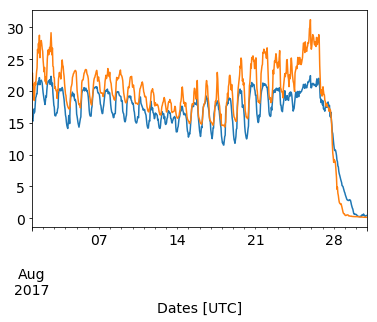

In [103]:
(0.33*df['MIDG: Salinity'] + 0.33*df['BOLI: Salinity'] + 0.33*df['TRIN: Salinity'])['2017-8-1':'2017-8-30'].plot()
df['MIDG: Salinity']['2017-8-1':'2017-8-30'].plot()

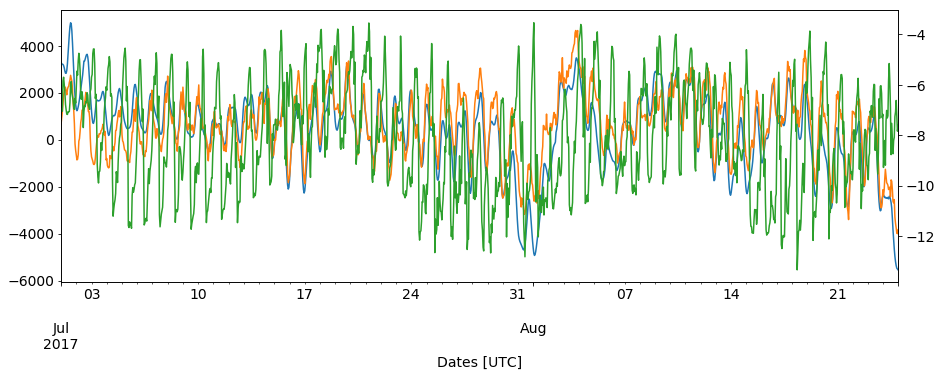

In [104]:
Qch.rolling(window=72, min_periods=10, center=True).mean()['2017-7-1':'2017-8-24'].plot(figsize=(15,5))
ax = Qch1b.rolling(window=72, min_periods=10, center=True).mean()['2017-7-1':'2017-8-24'].plot(figsize=(15,5))
# (dVdt.rolling(window=72, min_periods=10, center=True).mean()*5)['2017-7-1':'2017-8-24'].plot(figsize=(15,5))
# dVwdt.rolling(window=72, min_periods=10, center=True).mean()['2017-7-1':'2017-8-24'].plot(figsize=(15,5))
(S - df['BOLI: Salinity'])['2017-7-1':'2017-8-24'].plot(secondary_y=True, ax=ax)

The influx of water looks reasonable during the storm, as seen in the figure below.

In [106]:
cols = ['08078000: Flow rate [m^3/s]', '08077600: Flow rate [m^3/s]', '08074500: Flow rate [m^3/s]', 
        '08068500: Flow rate [m^3/s]', '08068090: Flow rate [m^3/s]', '08070500: Flow rate [m^3/s]', '08071000: Flow rate [m^3/s]', 
        '08070200: Flow rate [m^3/s]', '08071280: Flow rate [m^3/s]', '08067252: Flow rate [m^3/s]', 
        '08067000: Flow rate [m^3/s]', '08077650: Flow rate [m^3/s]', '08073600: Flow rate [m^3/s]']


(-2000, 4000)

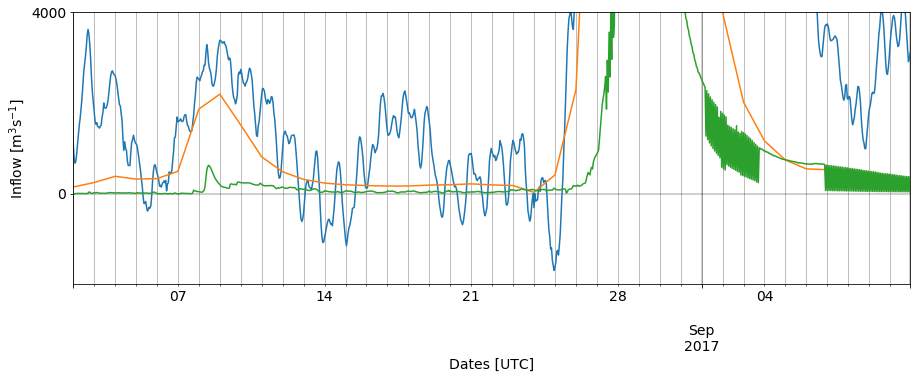

In [150]:
# Qin['2017-8-2':'2017-9-10'].plot(figsize=(15,15), grid=True)
(Qin['2017-8-2':'2017-9-10'].rolling(window=72, min_periods=1, center=True).mean()).plot(figsize=(15,5), grid=True)
ax=inf['2017-8-2':'2017-9-10'].plot()
df.loc['2017-8-2':'2017-9-10',cols].sum(axis=1).plot(ax=ax)
plt.grid(which='major', lw=1.5, color='k', alpha=0.25)
plt.grid(which='minor', lw=1, color='k', alpha=0.25)
plt.ylabel('Inflow [m$^3$s$^{-1}$]')
plt.yticks(np.arange(-20000,40000,4000))
plt.ylim(-2000,4000)
# df['8771013: Water Level [m]']['2017-8-2':'2017-9-10'].plot(secondary_y=True)
# df['smean']['2017-8-2':'2017-9-10'].plot(secondary_y=True)

# plt.savefig('figures/Qin_only.pdf', bbox_inches='tight')

# Inflow sum

Use cumulative sums to examine inflow since signal is wiggly.


In [132]:
Vincum = Qin.cumsum()*3600  # multiply by time for integration, m^3


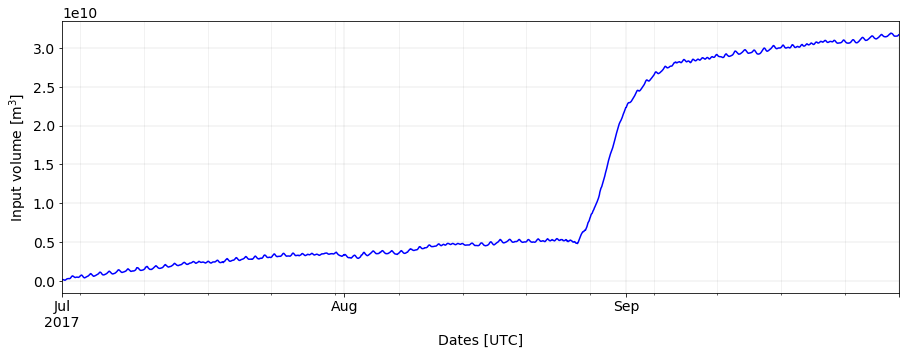

In [133]:
dst3 = '2017-7-1'; den3 =  '2017-9-30'
ax = Vincum[dst3:den3].plot(figsize=(15,5), grid=True, color='b')
ax.set_ylabel('Input volume [m$^3$]')

# dpre = '2017-8-1'  # start of pre-storm
# dstorm = '2017-8-26 12:00'  # start of storm
# dpost = '2017-9-2 00:00'  # post storm
# # ax.vlines(dstorm, 0,3e10)
# # ax.vlines(dpost, 0,3e10)

ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
ax.grid(which='minor', lw=1, color='k', alpha=0.05)


## Inflow before storm (check)

Add up in flow before storm and compare with TWDB watershed calculation.

In [110]:
# LINEAR REGRESSION FOR JULY AND AUGUST
# inflow from 8/1 through 8/24
Qb = (Vincum.loc['2017-8-24 23:00'] - Vincum.loc['2017-8-1 00:00'])/1000**3
print(Qb)
print(Qb*(1000**3)/(86400*24))

0.635015612477
306.238239042


In [134]:
# LINEAR REGRESSON FOR ONLY AUGUST
# inflow from 8/1 through 8/24
Qb = (Vincum.loc['2017-8-24 23:00'] - Vincum.loc['2017-8-1 00:00'])/1000**3
print(Qb)
print(Qb*(1000**3)/(86400*24))

1.97034418251
950.204563326


819.28778895888
1.60319757463


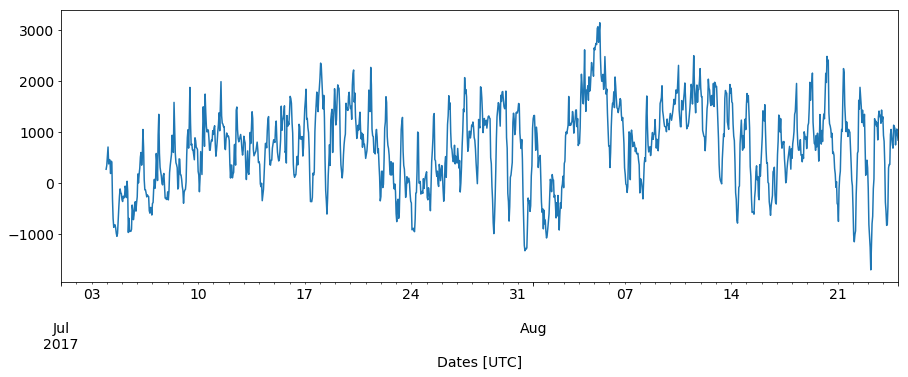

In [135]:
Qrobustin = Qch1b + dVdt + dVwdt
print(Qrobustin['2017-8-1 00:00':'2017-8-24 23:00'].mean())
Vtemp1 = Qrobustin.cumsum()*3600
print((Vtemp1.loc['2017-8-24 23:00'] - Vtemp1.loc['2017-8-1 00:00'])/1000**3)
Qrobustin['2017-7-1 00:00':'2017-8-24 23:00'].rolling(window=72).mean().plot(figsize=(15,5))

In [112]:
# from Nelun for TWDB watershed calculation
infg = pd.read_csv('drive_data/daily_gauged_galv_1Aug_30Sep2017.csv', parse_dates=True, index_col=0)['sum_afd']
convert = 0.0142764  # 1 acre-foot per day = 0.0142764 m^3/s
infg *= convert
infug = pd.read_csv('drive_data/fresh_in_modelled_galv_1aug2017_to_30sep2017.txt', parse_dates=True, index_col=0, skiprows=1, header=None, names=['Dates', 'ungauged'])
infug *= convert
# total inflow is sum of ungauged and gauged inflow
inf = infug['ungauged'] + infg

In [143]:
# multiply by seconds per day to get volume
QTWDB = (inf['2017-8-1':'2017-8-24']*86400).sum()/1000**3
print(QTWDB*(1000**3)/(86400*24))

463.2112237645


In [144]:
# multiply by seconds per day to get volume
QTWDB = (inf['2017-8-1':'2017-8-24']*86400).sum()/1000**3
print(QTWDB)

0.9605147935980671


# Volume input to bay

We compare the time periods to decide what flooding time period to average over (below). 

Based on this, we define the flooding time period to be from 2017-8-26 16:00 through 2017-9-2.

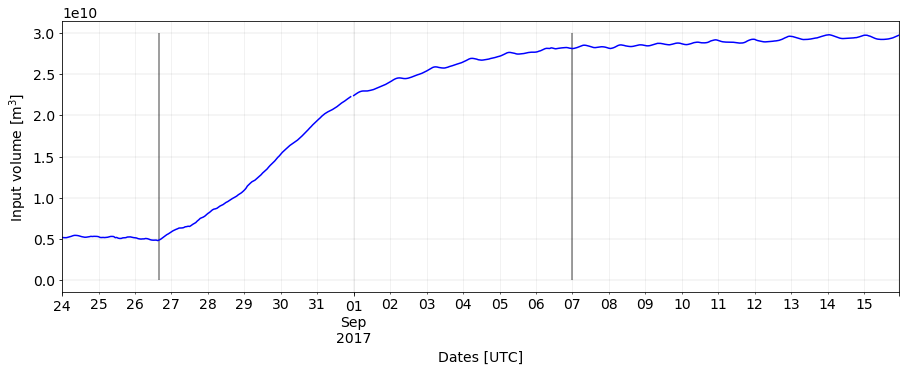

In [136]:
dst4 = '2017-8-24'; den4 =  '2017-9-15'
ax = Vincum[dst4:den4].plot(figsize=(15,5), grid=True, color='b')
ax.set_ylabel('Input volume [m$^3$]')


# dpre = '2017-8-1'  # start of pre-storm
dstorm = '2017-8-26 16:00'  # start of storm
dpost = '2017-9-7  00:00' # '2017-9-5 00:00'  # post storm
ax.vlines(dstorm, 0,3e10, alpha=0.5)
ax.vlines(dpost, 0,3e10, alpha=0.5)

ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
ax.grid(which='minor', lw=1, color='k', alpha=0.05)


This gives a total input flow of:

In [137]:
Vin = (Vincum[dpost] - Vincum[dstorm])/1000**3  # km^3
print(Vin)

23.2383648099


## Compare with TWDB

In [138]:
# multiply by seconds per day to get volume
QTWDBharvey = (inf[dstorm:dpost]*86400).sum()/1000**3
print(QTWDBharvey)

12.796363731169961


## Compare with volume of Galveston Bay

Average depth of Galveston Bay:

In [139]:
# Galveston Bay volume with west bay too
Vfull = (Afull*Hfull)/1000**3  # km^3
print(Vfull)

2.61561758792


This means that the flood water could fill the bay approximately:

In [140]:
print(Vin/Vfull)

8.88446572513


times.

## Compare with the precipitation estimates over Texas

In [141]:
precipgals = 20e12  # gallons
precip = precipgals*0.00378541  # m^3, 1 gallon = 0.00378541 m^3
precip /= 1000**3
precip  # km^3

75.7082

ratio of rain that ended up in Galveston Bay

In [142]:
Vin/precip

0.30694647092317034

## Compare with daily discharge from Mississippi

In [488]:
Qmiss = 16792  # m^3/s, wikipedia, max 86791
Vmiss = Qmiss*86400  # m^3
Vmiss /= 1000**3
Vmiss

1.4508288

14 times avergae mississippi daily average

In [489]:
Vin/Vmiss

14.320885780629695

In [ ]:
DO FLOW RATE